In [1]:
import xgboost as xgb
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
%matplotlib inline

from imblearn.over_sampling import SMOTE

smote = SMOTE()

In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

def print_metrics(labels, preds, X_test, y_train, y_hat_train):
 
        plot_confusion_matrix(model, X_test, y_test, values_format='.3g')
        
        print('Training Precision: ', precision_score(y_train, y_hat_train, average='macro'))
        print('Testing Precision: ', precision_score(labels, preds, average='macro'))
        print('Training Recall: ', recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall: ', recall_score(labels, preds, average='macro'))
        print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
        print('Testing Accuracy: ', accuracy_score(labels, preds))
        print('Training F1-Score: ', f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score: ', f1_score(labels, preds, average='macro'))
        

In [3]:
df = pd.read_csv('Data/churm_data_cleaned.csv')
df.head()#in the churn column True = 0, False = 1
#in the international plan and voice mail plan columns, yes = 0, no = 1

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,1,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1
1,107,415,1,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1
2,137,415,1,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,1
3,84,408,0,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1
4,75,415,0,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1


In [4]:
df.shape

(3333, 19)

In [5]:
# Checking to see how the target varible is split up
def value_counts(col):
    print('Raw counts: \n')
    print(col.value_counts())
    print('-----------------------------------')
    print('Normalized counts: \n')
    print(col.value_counts(normalize=True))
value_counts(df['churn'])#15% yes (people leaving), 85% no (people staying)

Raw counts: 

1    2850
0     483
Name: churn, dtype: int64
-----------------------------------
Normalized counts: 

1    0.855086
0    0.144914
Name: churn, dtype: float64


In [6]:
# Splitting the target varible from the rest of the data set
y = df['churn']
X = df.drop('churn', axis=1, inplace=False)

## Train Test Split:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

## Resampling the data:

In [8]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({1: 2284, 0: 382})


In [9]:
# Using Tomek Links to split the training data into more well defined clusters
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 2174, 0: 382})


In [10]:
X_res, y_res = tl.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 2147, 0: 382})


In [11]:
#Need to turn the data into a DMatrix before we pass it through XGBoost
D_train = xgb.DMatrix(X_res, label=y_res)
D_test = xgb.DMatrix(X_test, label=y_test)

In [12]:
y_train = y_res
X_train = X_res

## Fitting the Model:

In [13]:
param = {}

In [14]:
#Creating the classifier
model = xgb.train(param, D_train, num_boost_round = 100)

# Predict on the test set
test_preds = model.predict(D_test)
train_preds = model.predict(D_train)

In [15]:
#Checking the test and train scores
best_preds = np.asarray([np.argmax(line) for line in test_preds])
best_preds_train = np.asarray([np.argmax(line) for line in train_preds])


print('Training Precision: ', precision_score(y_train, best_preds_train, average='macro'))
print('Testing Precision: ', precision_score(y_test, best_preds, average='macro'))
print('Training Recall: ', recall_score(y_train, best_preds_train, average='macro'))
print('Testing Recall: ', recall_score(y_test, best_preds, average='macro'))
print('Training Accuracy: ', accuracy_score(y_train, best_preds_train))
print('Testing Accuracy: ', accuracy_score(y_test, best_preds))
print('Training F1-Score: ', f1_score(y_train, best_preds_train, average='macro'))
print('Testing F1-Score: ', f1_score(y_test, best_preds, average='macro'))

cm = confusion_matrix(y_test, (best_preds>0.5))
print(('The Confusion Matrix is: '),'\n', cm)

Training Precision:  0.07552392249901146
Testing Precision:  0.07571214392803598
Training Recall:  0.5
Testing Recall:  0.5
Training Accuracy:  0.15104784499802293
Testing Accuracy:  0.15142428785607195
Training F1-Score:  0.13122638268636208
Testing F1-Score:  0.13151041666666666
The Confusion Matrix is:  
 [[101   0]
 [566   0]]


## Running Gridsearch:

In [16]:
#Running GridSearch to find the most optimal 
clf = xgb.XGBClassifier()
parameters = {
    'eta': [0.005, 0.01, 0.02, 0.3],  
    'max_depth': [2, 3, 4, 5, 6],  
    'objective': ['multi:softprob', 'multi:softmax'],
    'num_class': [2, 3, 4, 5]} 

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="recall",
                    cv=5,
                    verbose=3)
#                     return_train_score=True)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:  1.7min finished


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=4,
             param_grid={'eta': [0.005, 0.01, 0.02, 0.3],
                         'max_depth': [2, 3, 4, 5, 6],
                         'num_class': [2, 3, 4, 5],
                         'objective': ['multi:softprob', 'multi:softmax']},
             scoring='recall', verbose=3)

In [17]:
grid.best_params_

{'eta': 0.005, 'max_depth': 6, 'num_class': 2, 'objective': 'multi:softprob'}

In [18]:
params_final = {'eta': 0.005, 'max_depth': 6, 'num_class': 2, 'objective': 'multi:softprob'}

## Refitting the Model:

In [19]:
model = xgb.train(params_final, D_train, num_boost_round = 100)

# Fit the classifier
# clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = model.predict(D_test)
train_preds = model.predict(D_train)

In [20]:
best_preds = np.asarray([np.argmax(line) for line in test_preds])
best_preds_train = np.asarray([np.argmax(line) for line in train_preds])


print('Training Precision: ', precision_score(y_train, best_preds_train, average='macro'))
print('Testing Precision: ', precision_score(y_test, best_preds, average='macro'))
print('Training Recall: ', recall_score(y_train, best_preds_train, average='macro'))
print('Testing Recall: ', recall_score(y_test, best_preds, average='macro'))
print('Training Accuracy: ', accuracy_score(y_train, best_preds_train))
print('Testing Accuracy: ', accuracy_score(y_test, best_preds))
print('Training F1-Score: ', f1_score(y_train, best_preds_train, average='macro'))
print('Testing F1-Score: ', f1_score(y_test, best_preds, average='macro'))

cm = confusion_matrix(y_test, (best_preds>0.5))
print(('The Confusion Matrix is: '),'\n', cm)

Training Precision:  0.9723945316926821
Testing Precision:  0.9157864334048522
Training Recall:  0.8862701395103847
Testing Recall:  0.8525522163523773
Training Accuracy:  0.9640173981810992
Testing Accuracy:  0.9430284857571214
Training F1-Score:  0.9229821376281113
Testing F1-Score:  0.8802173913043478
The Confusion Matrix is:  
 [[ 73  28]
 [ 10 556]]


## Feature Importance:

In [21]:
model.get_score(importance_type='gain')

{'total day minutes': 12.256599754262341,
 'customer service calls': 34.66702330505799,
 'international plan': 11.497913125135756,
 'total intl calls': 12.02913982333334,
 'total intl minutes': 12.508335373058173,
 'total eve minutes': 5.116188415507278,
 'number vmail messages': 0.5200236057503269,
 'total day calls': 0.608268129506604,
 'voice mail plan': 13.93933575054544,
 'total eve calls': 0.553775402680793,
 'total night calls': 0.873028187431884,
 'total night minutes': 1.1726376506250282,
 'account length': 0.4610846173936655,
 'area code': 0.8445660736874999}

In [22]:
# Turnning model.get_score to into a dataframe
df1 = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient='index')
df1

,0
total day minutes,12.256600
customer service calls,34.667023
international plan,11.497913
total intl calls,12.029140
total intl minutes,12.508335
total eve minutes,5.116188
number vmail messages,0.520024
total day calls,0.608268
voice mail plan,13.939336
total eve calls,0.553775


In [23]:
df1.reset_index(level=0, inplace=True)

In [24]:
df1 = df1.rename(columns={"index": "columns", 0: "f_importance"})
print(df1)

                   columns  f_importance
0        total day minutes     12.256600
1   customer service calls     34.667023
2       international plan     11.497913
3         total intl calls     12.029140
4       total intl minutes     12.508335
5        total eve minutes      5.116188
6    number vmail messages      0.520024
7          total day calls      0.608268
8          voice mail plan     13.939336
9          total eve calls      0.553775
10       total night calls      0.873028
11     total night minutes      1.172638
12          account length      0.461085
13               area code      0.844566


In [56]:
df1 =df1.sort_values('f_importance', ascending=False)

In [25]:
# df1 = df1.rename(columns={0: "f_importance"})

In [26]:
df1.columns

Index(['columns', 'f_importance'], dtype='object')

Text(0.5, 1.0, 'XGBoost Feature Importance')

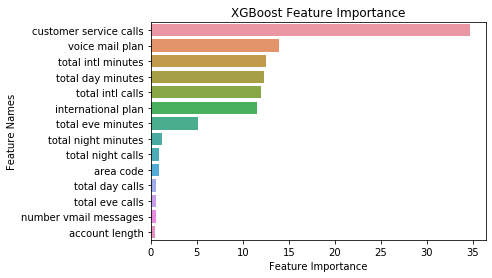

In [57]:
#Plotting Future importance
ax = sns.barplot(x="f_importance", y="columns", data=df1)
ax.set(xlabel='Feature Importance', ylabel='Feature Names')
ax.set_title('XGBoost Feature Importance')